# **Lab experience #6 (SOLUTION): Comparison and validation of different clustering solutions**

This sixth lab session aims **to compare and validate two different solutions of clustering (k-means, hierarchical)** applied to an unknown matrix of data (with low dimensionality and continuous attributes). This lab session refers to Prof. Stella's lectures no.5, 6 and 8 "Cluster Analysis: k-means", "Cluster Analysis: hierarchical clustering", and "Cluster Analysis: Clustering validation".

In this lab, you are going to **(re-)use already developed code**: check solutions of Lab03, Lab04, Lab05.
Moreover, some new measures/strategies for validating clustering solutions will be used.

Today, **both hierarchical and k-means will be applied, with their own validation strategies**. Finally, comparison will be operated to finally guess the clusters, and cross-check with the true labels _(given at the end of the session)_.

**For kmeans, two different strategies** will be implemented:
1. running hierarchical clustering, find a candidate number of clusters, then run kmeans with that given number,
2. use the elbow method and find the best candidate number of clusters only using kmeans.

Notes:
*   to rapidly access the documentation you can also create a new code cell and type in "function_name?" (e.g., matplotlib?) and run the cell.
*   to execute the code, click on the corresponding cell and press the SHIFT-ENTER keys simultaneously or click on the "play" icon.


**Read the step-by-step instructions below** carefully and write your own code to fill the missing steps. There are no **guiding slides** for this lab session.

## NOTATION TO USE:
To uniquely identify the number of clusters in the two different clustering solutions, we will use the following notation:


> ```
> Kh = number of clusters for the hierarchical clustering solution
> Km = number of clusters for the k-means++ clustering solution
> ```


Similarly, for the labels assigned by the two algorithms, we will name:
> ```
> hierarchical_labels = the labels assigned by the hierarchical clustering solution
> kmeans_labels       = the labels assigned by the k-means++ clustering solution
> ```


# **Step 1**: Load and visualize the input data, and import useful packages

In this cell, you load **the input data, a 2D matrix synthetically created**. The matrix has 10 columns (for the attributes or features) and 130 rows that we assume to represent the collection of objects (also called observations or items).

---
> This time the number of clusters (K) is _not_ given.

> For the last task, you will be given with the _true labels_.
---

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


# Load the dataset
# ----------------
X = np.load("Dataset_lab06.npy")
[N,M] = np.shape(X)    # N=no. of objects, M=no. of attributes

print("The matrix has shape = ", np.shape(X))
print('It has %d objects and %d attributes.' % (N, M) )

The matrix has shape =  (200, 15)
It has 200 objects and 15 attributes.


In [ ]:
# Define a palette of colours for the K clusters (useful for the next tasks)
PAL = ['black', 'red', 'green', 'blue', 'yellow', 'orange', 'purple', 'magenta', 'cyan', 'brown']

**Choose the distance metric you want to use to compute proximity for the dataset and in the clustering solutions**

In [ ]:
# Possible choices: 'euclidean', 'minkowski', 'mahalanobis',  'hamming'/'matching', 'jaccard', 'cosine', 'correlation'
distance_metric = 'euclidean'

**Note**: remember the way (distance metric choice) you use to compute the proximity matrix. It will be useful to compare it with the clustering solutions (where you might have used different distance metrics).

In [ ]:
# Visualize the dataset. Hint: you can use an image, a "D scatterplot, PCA, tSNE, proximity matrix (see useful code/functions at the bottom)
# ---------------------

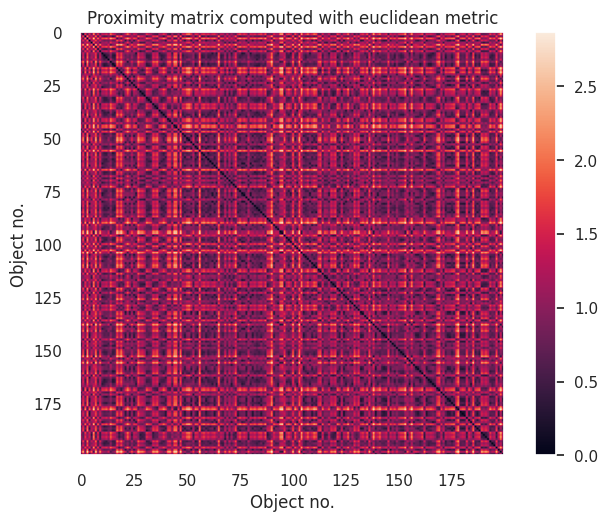

In [ ]:
# [USING CODE SNIPPET PROVIDED BELOW] Proximity matrix: to have an idea of how "similar" are the objects in the dataset
from scipy.spatial.distance import pdist as pdist
from scipy.spatial.distance import squareform as sf

PM = pdist(X, metric=distance_metric)
PM = sf(PM).round(2)

# Plot the proximity matrix using imshow()
plt.figure()
plt.imshow(PM)
plt.xlabel('Object no.')
plt.ylabel('Object no.')
plt.title('Proximity matrix computed with %s metric' % distance_metric)
plt.colorbar()
plt.show()

From the proximity matrix, this time, we _cannot_ derive any easy hypothesis. In fact, this time the data objects were shuffled in the dataset.

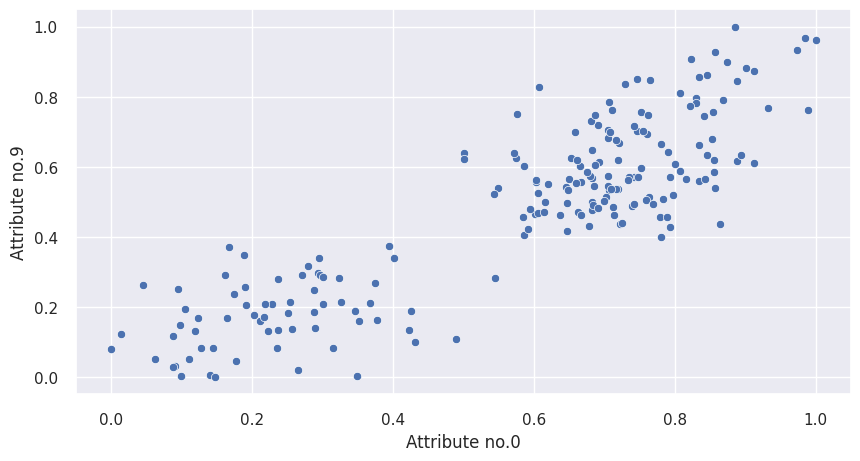

In [ ]:
# 2D scatterplot with two random features
feat1 = 0
feat2 = 9
fig2 = plt.figure('Check the dataset', figsize=(10,5))
sns.scatterplot( x = X[:,feat1], y = X[:,feat2] )
sns.set_theme(style='dark')
plt.xlabel('Attribute no.%s' % feat1)
plt.ylabel('Attribute no.%s' % feat2)
plt.grid()
plt.show()

PCA: explained variation per principal component: [0.7  0.08]

Applying tSNE...


<ipython-input-12-76933469a680>:40: UserWarning: The palette list has more values (10) than needed (1), which may not be intended.
  sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1], ax=ax1, hue=LABELS, palette=PAL)
<ipython-input-12-76933469a680>:47: UserWarning: The palette list has more values (10) than needed (1), which may not be intended.
  sns.scatterplot(x=tsne_results[:,0], y=tsne_results[:,1], ax=ax2, hue=LABELS, palette=PAL)


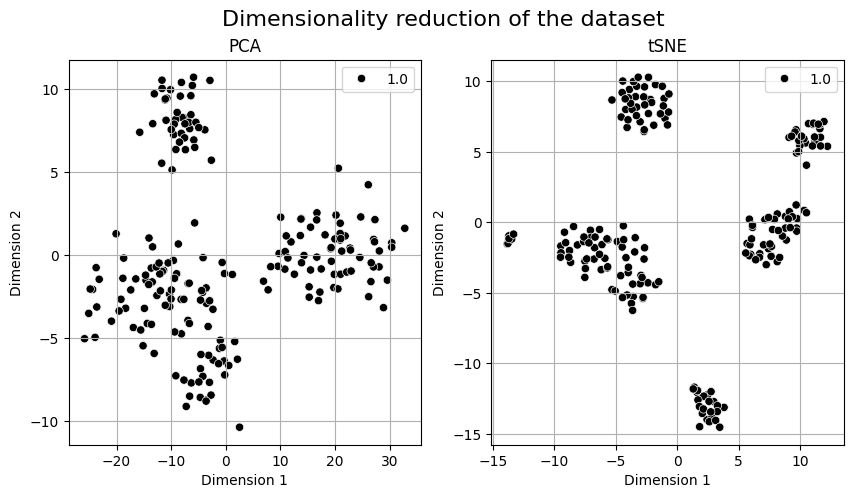

In [ ]:
PCA_tSNE_visualization(X, 2, np.ones(N), PAL)

We can reasonably expect that the dataset includes 3 to 6 clusters, as per the results of the PCA and tSNE.

# **Step 2**: Prepare the dataset

Here, you can decide _whether, or not,_ to scale your data.

In [ ]:
# Scaling
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler, RobustScaler

# StandardScaler: z = (x - u) / s
#
# RobustScaler: it removes the median and scales the data according to the quantile range (defaults to IQR: Interquartile Range).
#               The IQR is the range between the 1st quartile (25th quantile) and the 3rd quartile (75th quantile).
# Normalizer:   Each sample (i.e. each row of the data matrix) with at least one non-zero component is rescaled
#               independently of other samples so that its norm (l1, l2 or inf) equals one.
# MinMaxScaler: Transform features by scaling each feature to a given range.
#               X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
#               X_scaled = X_std * (max - min) + min
#               scaler = MinMaxScaler(feature_range=(-1, 1))


# Initialize the scaler you want to use
scaler = MinMaxScaler()

# Apply the scaling to data  --- SLIGHTLY CHANGED!! ---
X = scaler.fit_transform(X)

# **Step 3**: Design and apply hierarchical (agglomerative) clustering (see Lab05)

1. Choose the parameters:
* choose a **linkage method**: _'ward', 'complete', 'average', 'single',  'median'_
* choose a **metric**: _'euclidean', 'minkowski', 'correlation’, ‘cosine’_
* choose the **number of desired clusters** (the threshold to cut the dendrogram)

> ```
> # As an example
> method_merging = 'ward'
> distance_metric = 'euclidean'
> ```

In [ ]:
# Import useful packages for clustering
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist as pdist
from scipy.spatial.distance import squareform as sf
from sklearn.metrics import silhouette_score

In [ ]:
# Choose the parameters to run hierarchical clustering (the metric to compute the distance between instances/clusters and the method to merge clusters)
method_merging = 'ward'
distance_metric = 'euclidean'


2. Apply the algorithm to find the hierarchy or linkage matrix (Z):

> ```
>  Z = hierarchy.linkage(X, method_merging, metric=distance_metric, optimal_ordering='true')
> ```



In [ ]:
# Apply the algorithm to obtain the hierarchy
  # input - instances with their features, metric, method
  # output - condensed distance matrix, Z
Z = hierarchy.linkage(X, method_merging, metric=distance_metric, optimal_ordering='true')

3. Print the linkage matrix

 > Remember that in the linkage matrix the **first and second elements** are the two clusters merged at each step, the **third element** is the distance between these clusters, and the **fourth element** is the size of the new cluster - the number of original data points included.

In [ ]:
# Print the linkage matrix after clustering
print("Linkage matrix")
print(Z.round(2))

# Column 3 of Z contains all distances among pairs of clusters
print("\n Distances:")
print(*Z[:,2].round(2))

4. Visualize this clustering solution using the dendrogram. Hint: check documentation for ```hierarchy.dendrogram```

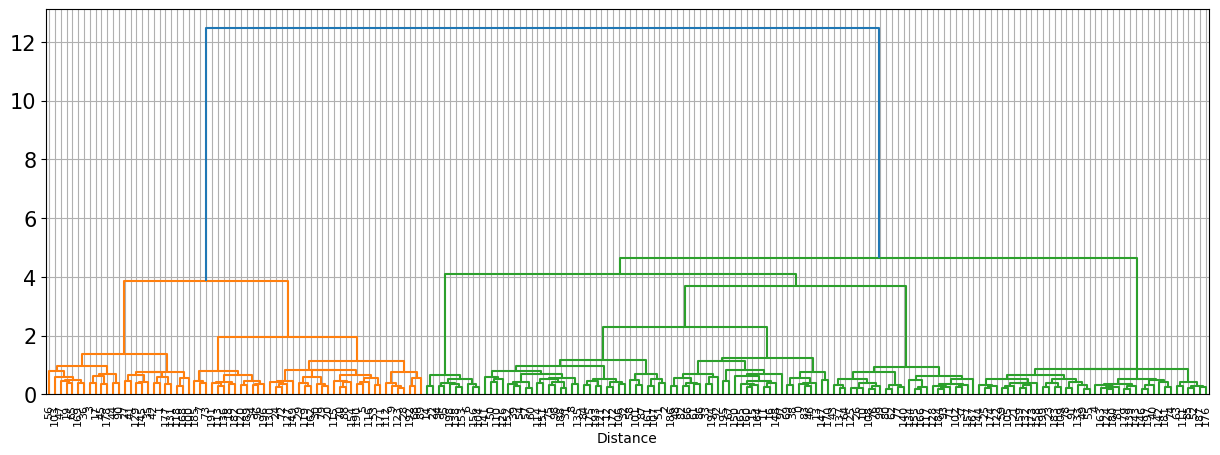

In [ ]:
# Visualize the DENDROGRAM of the corresponding clustering
fig4 = plt.figure(figsize=(15, 5))
dn = hierarchy.dendrogram(Z, no_plot=0)
plt.tick_params(axis='y', which='major', labelsize=15)
plt.tick_params(axis='x', which='major', labelsize=8)
plt.xlabel('Distance')
plt.grid()
plt.show()

5. You can decide where to cut the forest (max_d) created by the hierarchical algorithm. As expected from the visual inspection of the dataset (especially from the tSNE results), we should decide to cut the forest in order to obtain 3-6 clusters.

In [ ]:
# Cut the forest to have a certain inter-cluster distance (max_d)
max_d = 3

6. Obtain the corresponding ```Kh``` clusters, compute the centroids, and visualize the scatterplot/PCA/tSNE. Hint: check documentation for ```fcluster``` (check [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fcluster.html)).

> !! Attention: ```labels``` are automatically assigned by hierarchical clustering algorithm in a numerical format starting from **1**.
Therefore, subtract 1 in order for the labels to start from 0 (as in k-means++).

(200,)
[3 0 3 0 5 1 2 1 3 1 4 3 3 3 2 3 3 0 1 0 1 5 2 5 1 5 4 0 1 1 1 3 3 3 1 0 0
 4 3 3 5 0 0 4 0 0 3 0 3 5 3 3 5 1 3 5 0 3 3 5 3 3 4 5 4 0 3 3 1 3 1 4 1 1
 5 3 4 4 5 1 4 5 3 3 3 5 3 3 1 1 0 5 3 4 2 2 1 3 3 4 0 3 4 0 2 5 3 3 4 5 3
 5 1 1 3 1 1 4 0 1 1 3 5 1 5 4 3 1 4 0 1 0 5 5 4 3 1 4 2 5 4 3 5 5 5 0 5 3
 3 1 3 3 3 2 1 4 2 4 5 5 3 3 1 5 3 3 4 4 0 0 3 1 3 5 5 3 5 0 0 5 5 5 1 5 4
 1 3 5 3 1 1 1 1 3 3 3 1 5 2 5]
We got 6 cluster(s).


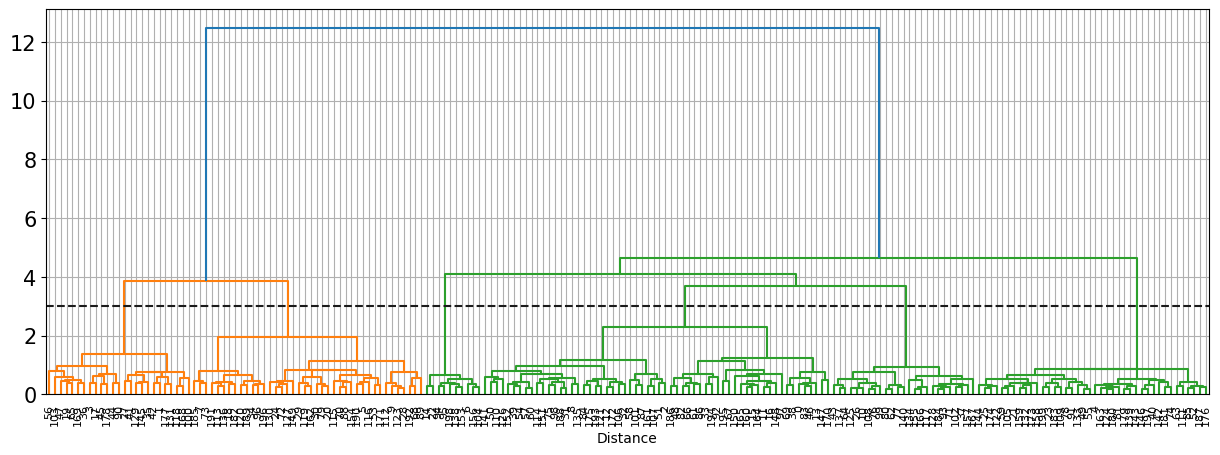

In [ ]:
# Form the clusters. Note: subtract 1 in order for the labels to start from 0 (as it happens in k-means++)
hierarchical_labels = fcluster(Z, max_d, criterion='distance') - 1

print(hierarchical_labels.shape)
print(hierarchical_labels)

# Confirm that you cut correctly, to have N clusters
Kh = hierarchical_labels.max() + 1
print("We got %d cluster(s)." % Kh)


# Add a vertical line to the dendrogram indicating the cut
plt.figure(fig4)
plt.axhline(y=max_d, color='k', linestyle='--')
plt.show()

In [ ]:
# Find clusters centers. Hint: utility function below
# centers = np.zeros((Kh,M))
centers = find_cluster_centers(X, Kh, hierarchical_labels)
print("\nWe need to compute %d centroids, as we have %d clusters." % (Kh, Kh) )

6 centroids are being computed, as we have 6 clusters.
The centroid of cluster 0 has coordinates:  0.22 0.23 0.22 0.22 0.26 0.27 0.31 0.18 0.22 0.21 0.41 0.33 0.23 0.18 0.25
The centroid of cluster 1 has coordinates:  0.24 0.5 0.27 0.47 0.35 0.17 0.24 0.54 0.47 0.16 0.43 0.52 0.25 0.42 0.46
The centroid of cluster 2 has coordinates:  0.88 0.55 0.75 0.92 0.84 0.92 0.79 0.96 0.92 0.91 0.75 0.88 0.9 0.62 0.83
The centroid of cluster 3 has coordinates:  0.74 0.75 0.75 0.66 0.53 0.7 0.46 0.7 0.61 0.69 0.54 0.69 0.64 0.78 0.67
The centroid of cluster 4 has coordinates:  0.69 0.73 0.49 0.48 0.51 0.49 0.67 0.54 0.56 0.53 0.45 0.81 0.34 0.78 0.84
The centroid of cluster 5 has coordinates:  0.72 0.73 0.59 0.87 0.67 0.73 0.34 0.68 0.46 0.51 0.84 0.47 0.4 0.78 0.63

We need to compute 6 centroids, as we have 6 clusters.


<ipython-input-46-2171cc1dc186>:3: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  sns.scatterplot(x=X[:,feat1], y=X[:,feat2], hue=hierarchical_labels, palette=PAL)


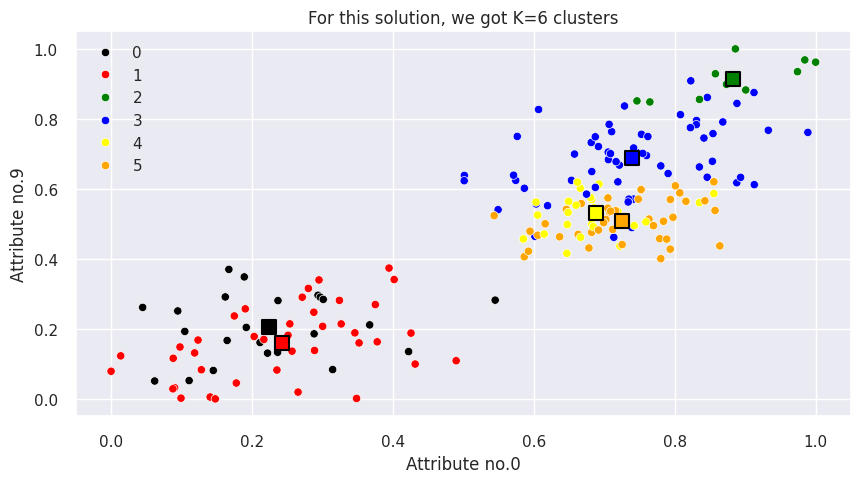

In [ ]:
# Visualize this clustering solution
fig5 = plt.figure('Hierarchical clustering (dendrogram cut at %.2f)' % max_d, figsize=(10,5))
sns.scatterplot(x=X[:,feat1], y=X[:,feat2], hue=hierarchical_labels, palette=PAL)
for k in range(Kh):
   plt.scatter(x=centers[k,feat1], y=centers[k,feat2], s=100, marker='s', edgecolor='black', linewidth=1.5, color=PAL[k])
sns.set_theme(style='dark')
plt.xlabel('Attribute no.%s' % feat1)
plt.ylabel('Attribute no.%s' % feat2)
plt.title("For this solution, we got K=%d clusters" % Kh)
plt.grid()
plt.show()

PCA: explained variation per principal component: [0.68 0.09]

Applying tSNE...


<ipython-input-12-76933469a680>:40: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1], ax=ax1, hue=LABELS, palette=PAL)
<ipython-input-12-76933469a680>:47: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  sns.scatterplot(x=tsne_results[:,0], y=tsne_results[:,1], ax=ax2, hue=LABELS, palette=PAL)


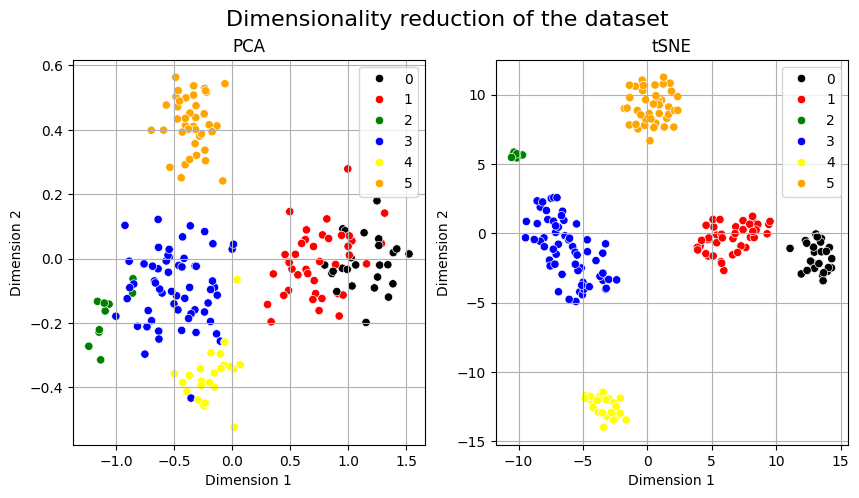

In [ ]:
# PCA/tSNE with this clustering solution
PCA_tSNE_visualization(X, 2, hierarchical_labels, PAL)

# **Step 4**: Validate the hierarchical clustering solution

> !!Attention: ```labels``` are automatically assigned by the algorithm in a numerical format starting from 1.

> a) compute the _inter-cluster distances_ and the _intra-cluster distances_. Hint: see Lab04, Lab05 and utility functions below.

> b) compute the _silhouette score_. Hint: see solution of Lab05.



In [ ]:
# Compute inter- and intra-cluster distances
dh, Dh = intra_inter_cluster_distances(X, Kh, hierarchical_labels, centers, distance_metric)

The intra-cluster distance of the clusters are:  [0.6  0.56 0.39 0.59 0.39 0.38]

All pair-wise inter-cluster distances:
 [[0.   0.7  2.3  1.67 1.46 1.6 ]
 [0.7  0.   1.94 1.28 1.06 1.21]
 [2.3  1.94 0.   0.9  1.24 1.14]
 [1.67 1.28 0.9  0.   0.62 0.59]
 [1.46 1.06 1.24 0.62 0.   0.83]
 [1.6  1.21 1.14 0.59 0.83 0.  ]]


In [ ]:
# Silhouette score
Sh = silhouette_score(X, hierarchical_labels, metric=distance_metric)
print("With hierarchical clustering, we found an optimal number of clusters equal to Kh=%d with a silhouette score of S=%.3f." % (Kh, Sh))

With hierarchical clustering, we found an optimal number of clusters equal to Kh=6 with a silhouette score of S=0.354.


**Note.** Don't worry if the silhouette score is pretty low. The distribution of the data points in this dataset (non homogenous clusters with a significant number of elements in each of them, different distances among each other, etc.) strongly impacts on that average clustering validation metric that is the _average silhouette score_. Suggestion: always use different validation methods to check the quality of your results.

**However, in this case this solution seems to provide a very good clusterization (see tSNE plot). Then, Kh=6 seems very good value.**

# **Step 5**: Design and apply k-means++ clustering

**Strategy #1: Use prior info from hierarchical clustering**
1. Set ```km = kh```, that is you use prior info on the possible number of clusters from the hierarchical clustering,
2. Run kmeans++ (see Lab04),
3. Name this clustering solution as ```kmeans1```.

**Strategy #2: Elbow method**
1. Run k-means++ for different choices of Km: let Km vary between 2 and 20,
2. For each Km, store the value of inertia (SSE) and apply the **elbow method**,
3. Name this clustering solution as ```kmeans2```.

In [ ]:
from sklearn.cluster import KMeans

NINIT = 10    # set n_init to a number >1, so to be sure to find the best solution

In [ ]:
# Strategy #1: Use prior info from hierarchical clustering
# --------------------------------------------------------
Km = Kh

# Run kmeans++
kmeans1         = KMeans(n_clusters=Km, init='k-means++', n_init=NINIT, max_iter=300, tol=0.0001, verbose=0, random_state=30).fit(X)
kmeans1_inertia = kmeans1.inertia_
kmeans1_labels  = kmeans1.labels_

print(kmeans1_inertia)

In [ ]:
# Strategy #2: Elbow method
# -------------------------

# Apply ELBOW METHOD to decide the optimal number of clusters for k-means++
inertia_values = np.zeros(19)

# Loop for computing the SSE for Km from 2 to 20
i=0
for k in range(2, 21):
    kmeans2 = KMeans(n_clusters=k, init='k-means++', n_init=NINIT, max_iter=300, tol=0.0001, verbose=0, random_state=30).fit(X)
    inertia_values[i] = kmeans2.inertia_
    i=i+1

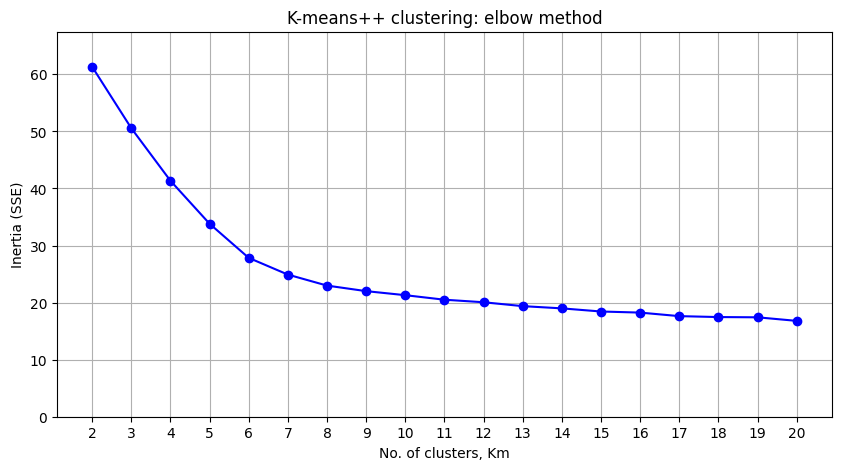

In [ ]:
# Elbow method. Hint: Plot SSE values vs the number of clusters
fig10 = plt.figure('K-means++ clustering: the elbow method', figsize=(10,5))
plt.plot(range(2,21), inertia_values, color='blue', marker="o", linestyle="-")
plt.xticks(np.arange(2, 21, step=1))
plt.xlabel('No. of clusters, Km')
plt.ylabel('Inertia (SSE)')
plt.ylim([0, 1.1*np.max(inertia_values)])
plt.title("K-means++ clustering: elbow method")
plt.grid()
plt.show()

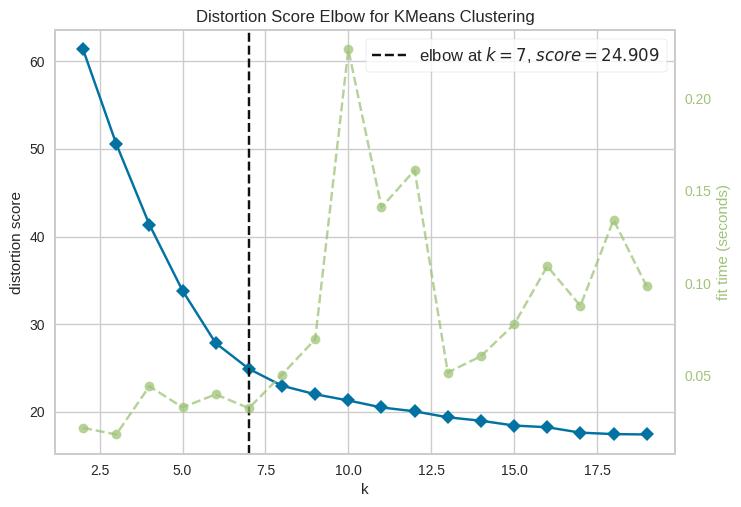

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
# Alternative (using KElbowVisualizer)
from yellowbrick.cluster import KElbowVisualizer
kmeans22 = KMeans(init='k-means++', n_init=NINIT, max_iter=300, tol=0.0001, verbose=0, random_state=30).fit(X)
visualizer = KElbowVisualizer(kmeans22, k=(2,20))
visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [ ]:
# Set the optimal number of clusters (given the "elbow point" on the plot above) and run the k-means++ algorithm with that choice.
Km = 6

# Compute the corresponding SSE value
SSEm = inertia_values[Km-2]

print('The best number of clusters is Km=%d with an SSE=%.2f '% (Km, SSEm))

The best number of clusters is Km=6 with an SSE=27.84 


# **Step 6**: Validate the k-means++ clustering solution

In [ ]:
# Define the best kmeans solutions: you need to choose between strategy#1 and strategy#2
# --------------------------------------------------------------------------------------

# If Km is different from the one provided by the hierarchical clustering, then run k-means++ with best choice of Km
kmeansBEST         = KMeans(n_clusters=Km, init='k-means++', n_init=NINIT, max_iter=300, tol=0.0001, verbose=0, random_state=30).fit(X)
kmeansBEST_labels  = kmeansBEST.labels_
kmeansBEST_inertia = kmeansBEST.inertia_
print(kmeansBEST_inertia)

!!Attention: ```labels``` are automatically assigned by k-means++ clustering algorithm in a numerical format starting from **0**.

<ipython-input-48-08ac9249a836>:3: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  sns.scatterplot(x=X[:,feat1], y=X[:,feat2], hue=kmeansBEST_labels, palette=PAL)


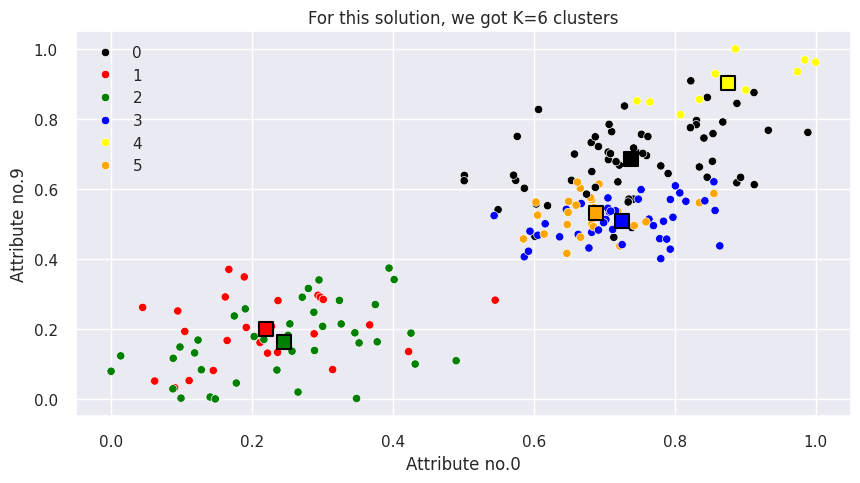

In [ ]:
# Visualize this clustering solution
fig6 = plt.figure('K-means++ clustering: scatterplot of best solution (elbow point at Km=%d)' % Km, figsize=(10,5))
sns.scatterplot(x=X[:,feat1], y=X[:,feat2], hue=kmeansBEST_labels, palette=PAL)
for k in range(Km):
  plt.scatter(x=kmeansBEST.cluster_centers_[k,feat1], y=kmeansBEST.cluster_centers_[k,feat2], s=100, color=PAL[k], marker='s', edgecolor='black', linewidth=1.5)
sns.set_theme(style='dark')
plt.xlabel('Attribute no.%s' % feat1)
plt.ylabel('Attribute no.%s' % feat2)
plt.title("For this solution, we got K=%d clusters" % Km)
plt.grid('on')
plt.show()

PCA: explained variation per principal component: [0.68 0.09]

Applying tSNE...


<ipython-input-12-76933469a680>:40: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1], ax=ax1, hue=LABELS, palette=PAL)
<ipython-input-12-76933469a680>:47: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  sns.scatterplot(x=tsne_results[:,0], y=tsne_results[:,1], ax=ax2, hue=LABELS, palette=PAL)


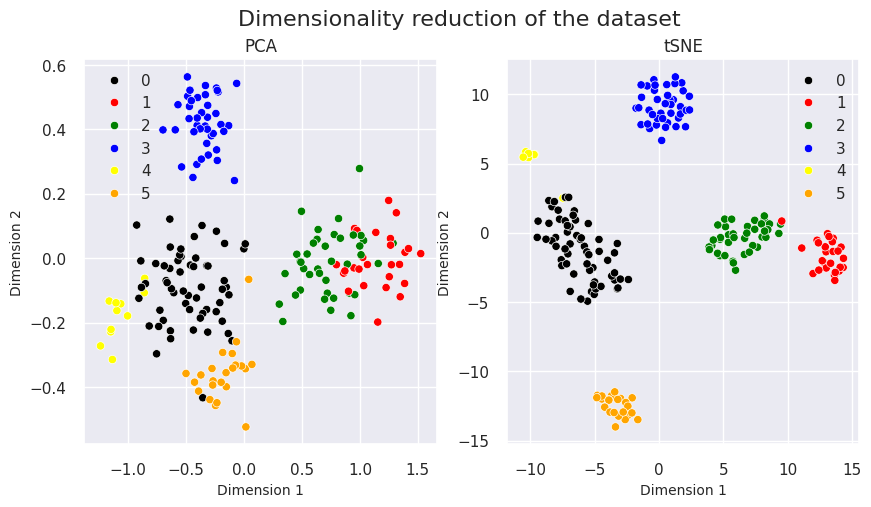

In [ ]:
PCA_tSNE_visualization(X, 2, kmeansBEST_labels, PAL)


> a) compute the _inter-cluster distances_ and the _intra-cluster distances_. Hint: see Lab04, Lab05 and utility functions below.

> b) compute the _silhouette score_. Hint: see solution of Lab05.

In [ ]:
# Compute inter- and intra-cluster distances
dm, Dm = intra_inter_cluster_distances(X, Km, kmeansBEST_labels, kmeansBEST.cluster_centers_, distance_metric)

The intra-cluster distance of the clusters are:  [0.59 0.61 0.55 0.38 0.45 0.39]

All pair-wise inter-cluster distances:
 [[0.   1.66 1.26 0.59 0.86 0.62]
 [1.66 0.   0.7  1.6  2.29 1.47]
 [1.26 0.7  0.   1.2  1.9  1.05]
 [0.59 1.6  1.2  0.   1.11 0.83]
 [0.86 2.29 1.9  1.11 0.   1.2 ]
 [0.62 1.47 1.05 0.83 1.2  0.  ]]


In [ ]:
# Compute silhouette score (Sm)
Sm = silhouette_score(X, kmeansBEST_labels, metric=distance_metric)

print("With k-means++ clustering, we found an optimal number of clusters equal to Km=%d with a silhouette score of S=%.3f." % (Km, Sm))

With k-means++ clustering, we found an optimal number of clusters equal to Km=6 with a silhouette score of S=0.352.


# **Step 7**: Comparison of the two clustering solutions
Here, you compare the hierarchical clustering solution with the best kmeans solution.

There are many indices and ways to compare two clustering solutions. Here, you are asked to compute/implement the following:

1. **Rand index (adjusted)**. Hint: use ```rand_score``` (in ```sklearn.metrics```). Check [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.rand_score.html).




_Disclaimer: before computing Rand index, I would suggest you to visually inspecting the match between the labels assigned by the two different clustering solutions using a simple line plot._

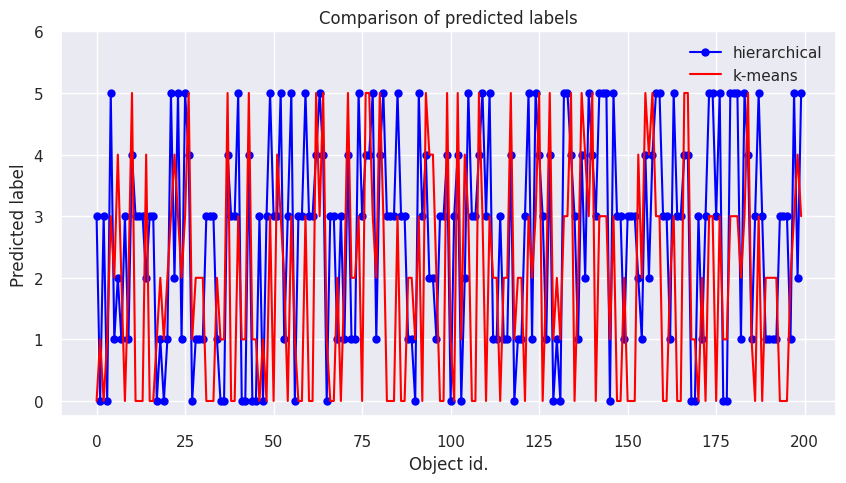

In [ ]:
# Define the two arrays of labels
y1 = hierarchical_labels   # predicted labels from hierarchical clustering
y2 = kmeansBEST_labels     # predicted labels from k-means clustering

fig20 = plt.figure('Comparison of predicted labels', figsize=(10,5))
plt.plot(y1, color='blue', marker="o", label='hierarchical')
plt.plot(y2, color='red', marker="x", label='k-means')
plt.xlabel('Object id.')
plt.yticks(np.arange(0,np.max([Km, Kh])+1))
plt.ylabel('Predicted label')
plt.title("Comparison of predicted labels")
plt.legend()
plt.grid()
plt.show()

**Note.** The above plot is not very informative. However, let's order the labels for both arrays of labels and plot it again.

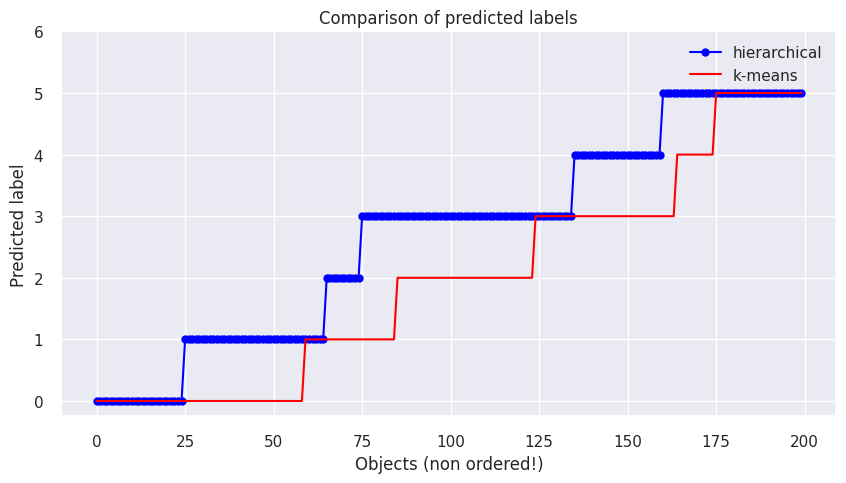

In [ ]:
# Re-ordering in ascending order
y1_ORDERED = np.sort(y1)
y2_ORDERED = np.sort(y2)

# New plot
fig20 = plt.figure('Comparison of predicted labels', figsize=(10,5))
plt.plot(y1_ORDERED, color='blue', marker="o", label='hierarchical')
plt.plot(y2_ORDERED, color='red', marker="x", label='k-means')
plt.xlabel('Objects (non ordered!)')
plt.yticks(np.arange(0,np.max([Km, Kh])+1))
plt.ylabel('Predicted label')
plt.title("Comparison of predicted labels")
plt.legend()
plt.grid()
plt.show()

**Note.** You can now appreciate a certain degree of coherence between the two clustering solutions. They assign 25 objects to cluster 0 (not necessary the same objects), other about 30 to cluster 1, etc. Then, in the hierarchical clustering solution there is one cluster (cluster 2) which accounts only a few data objects, similarly to cluster 4 of the k-means++ solution. Again, this is only a qualitative evaluation of the agreement between the two clustering solutions.

In [ ]:
# Compute the adjusted Rand score (R)
# -----------------------------------
from sklearn.metrics.cluster import adjusted_rand_score

R = adjusted_rand_score(y1, y2)
print(np.round(R,2))

0.98


2. **Correlation between the ideal similarity matrices from the two clustering solutions.**

    a) build the similarity matrix for each clustering solution. The similarity matrix has a 1 in the position (i,j) when objects i-th and j-th are assigned to the same cluster. Otherwise, the cell is zero-valued.
    
    b) compute correlation between each matrix with the proximity matrix

In [ ]:
# Build the similarity matrix for each clustering solution
# --------------------------------------------------------

# Ideal similarity matrix for hierarchical clustering
SM_hi = np.eye(N)
for i in range(0, y1.size):
   for j in range(0, y1.size):
       if y1[i] == y1[j]:
        SM_hi[i,j] = 1
        SM_hi[j,i] = 1


# Ideal similarity matrix for k-means++ clustering
SM_km = np.eye(N)
for i in range(0, y2.size):
   for j in range(0, y2.size):
       if y2[i] == y2[j]:
        SM_km[i,j] = 1
        SM_km[j,i] = 1

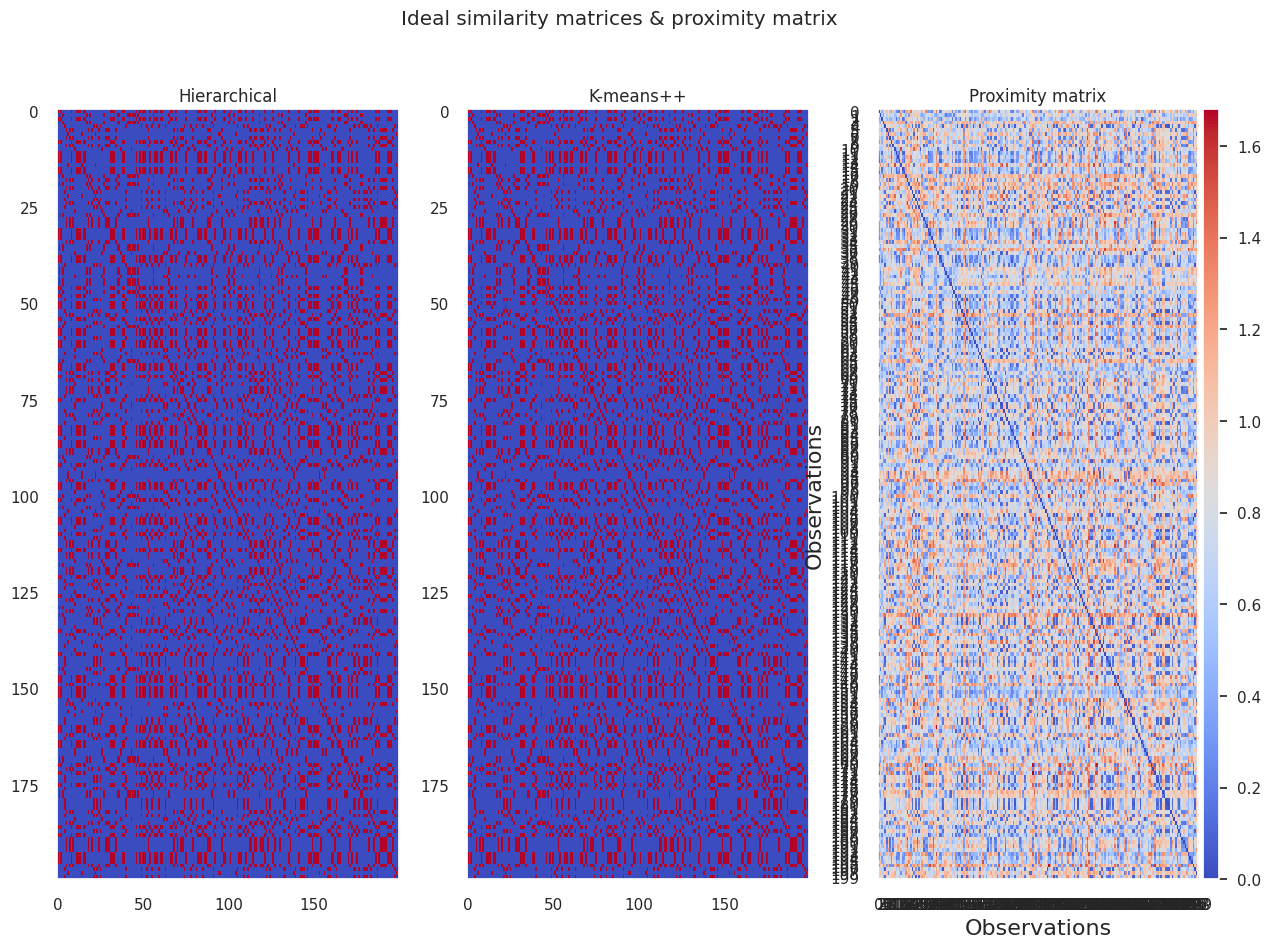

In [ ]:
# Visualization of the similarity matrices
# ----------------------------------------
# Hint: plot the two similarity matrix together with the proximity matrix

fig30 = plt.figure(figsize=(15,10))
fig30.suptitle('Ideal similarity matrices & proximity matrix')

ax1 = fig30.add_subplot(131)
ax1.imshow(SM_hi, interpolation='nearest', aspect='auto', cmap='coolwarm')
ax1.title.set_text('Hierarchical')

ax2 = fig30.add_subplot(132)
ax2.imshow(SM_km, interpolation='nearest', aspect='auto', cmap='coolwarm')
ax2.title.set_text('K-means++')

ax3 = fig30.add_subplot(133)
im3 = ax3.imshow(PM, interpolation='nearest', aspect='auto', cmap='coolwarm')
divider = make_axes_locatable(ax3)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im3, cax=cax)
ax3.set_xlabel('Observations', fontsize=16)
ax3.set_xticks(np.arange(0, N, step=1))
ax3.set_ylabel('Observations', fontsize=16)
ax3.set_yticks(np.arange(0, N, step=1))
ax3.title.set_text('Proximity matrix')
plt.show()

In [ ]:
# Compute the correlation between matrices
# ----------------------------------------
PM_values = PM[np.triu_indices_from(PM, k=1)]

# For the hierarchical clustering solution
SM_hi_values = SM_hi[np.triu_indices_from(SM_hi, k=1)]
ro_hi        = np.abs( np.corrcoef(PM_values, SM_hi_values)[0,1].round(2))

# k-means++ clustering
SM_km_values = SM_km[np.triu_indices_from(SM_km, k=1)]
ro_km        = np.abs( np.corrcoef(PM_values, SM_km_values)[0,1].round(2))


print('For the hierarchical clustering solution (with %d clusters),' % Kh, 'the cross-correlation is = %.2f.' % ro_hi)
print('For the k-means clustering solution (with %d clusters),' % Km, 'the cross-correlation is = %.2f.' % ro_km )

For the hierarchical clustering solution (with 6 clusters), the cross-correlation is = 0.73.
For the k-means clustering solution (with 6 clusters), the cross-correlation is = 0.72.


# **Step 8**: Cross-check your solutions

Here, you are given the true labels (see on Moodle), so you can decide how to check your (both) clustering solutions.

In [ ]:
TRUElabels = np.load("TRUElabels_lab06.npy")

In [ ]:
# Your way to cross-check your clustering solutions. Here, I list a number of measures you can pair-wisely use:

# For the hierarchical clustering solutions
from sklearn import metrics
print("For the hierarchical clustering solutions:")
print(f"Homogeneity: {metrics.homogeneity_score(y1, TRUElabels):.3f}")
print(f"Completeness: {metrics.completeness_score(y1, TRUElabels):.3f}")
print(f"V-measure: {metrics.v_measure_score(y1, TRUElabels):.3f}")
print(f"Adjusted Rand Index: {metrics.adjusted_rand_score(y1, TRUElabels):.3f}")
print("Adjusted Mutual Information:" f" {metrics.adjusted_mutual_info_score(y1, TRUElabels):.3f}")

print("\n")

# For the k-means++ clustering solutions
print("For the k-means++ clustering solutions:")
print(f"Homogeneity: {metrics.homogeneity_score(TRUElabels, y2):.3f}")
print(f"Completeness: {metrics.completeness_score(TRUElabels, y2):.3f}")
print(f"V-measure: {metrics.v_measure_score(TRUElabels, y2):.3f}")
print(f"Adjusted Rand Index: {metrics.adjusted_rand_score(TRUElabels, y2):.3f}")
print("Adjusted Mutual Information:" f" {metrics.adjusted_mutual_info_score(TRUElabels, y2):.3f}")


For the hierarchical clustering solutions:
Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000


For the k-means++ clustering solutions:
Homogeneity: 0.977
Completeness: 0.971
V-measure: 0.974
Adjusted Rand Index: 0.979
Adjusted Mutual Information: 0.973


PCA: explained variation per principal component: [0.68 0.09]

Applying tSNE...


<ipython-input-12-76933469a680>:40: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1], ax=ax1, hue=LABELS, palette=PAL)
<ipython-input-12-76933469a680>:47: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  sns.scatterplot(x=tsne_results[:,0], y=tsne_results[:,1], ax=ax2, hue=LABELS, palette=PAL)


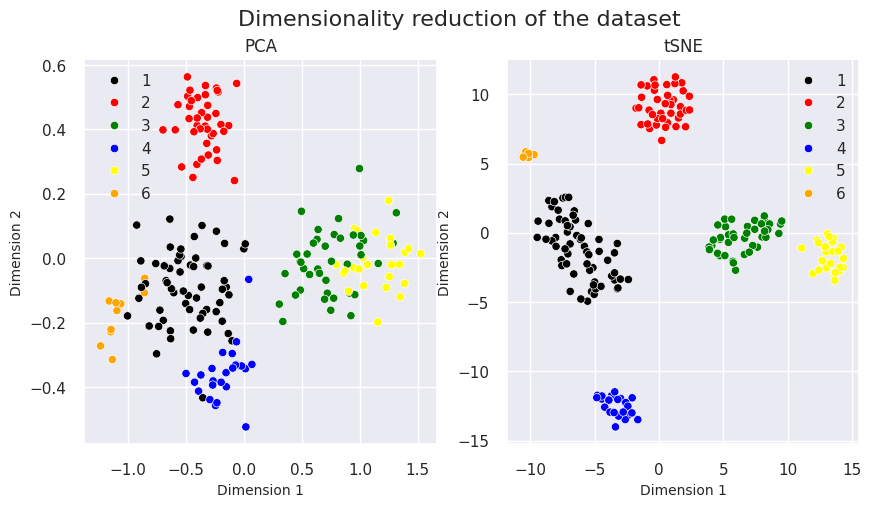

In [ ]:
# PCA/tSNE plot using the TRUE labels
PCA_tSNE_visualization(X, 2, TRUElabels, PAL)

--------------------------------------------------------------

# Utility snippets of code or functions

In [ ]:
# Proximity matrix: to have an idea of how "similar" are the objects in the dataset
from scipy.spatial.distance import pdist as pdist
from scipy.spatial.distance import squareform as sf

# distance_metric = 'correlation'                    # You can choose one among the following: 'euclidean', 'minkowski', 'mahalanobis',  'hamming'/'matching', 'jaccard', 'cosine', 'correlation'
PM = pdist(X, metric=distance_metric)
PM = sf(PM).round(2)

In [ ]:
# [FROM SOLUTION OF LAB#4] THIS IS A **METHOD** THAT YOU CAN USE IN THE NEXT LAB SESSIONS TO find visualize data in 2D with clusters in different colours

def PCA_tSNE_visualization(data2visualize, NCOMP, LABELS, PAL):

  '''
  INPUT
  data2visualize    - data matrix to visualize
  NCOMP             - no. of components to decompose the dataset during PCA
  LABELS            - labels given by the clustering solution
  PAL               - palette of colours to distinguish between clusters
  '''

  '''
  OUTPUT
  Two figures: one using PCA and one using tSNE
  '''


  # PCA
  from sklearn.decomposition import PCA
  pca = PCA(n_components=NCOMP)
  pca_result = pca.fit_transform(data2visualize)
  print('PCA: explained variation per principal component: {}'.format(pca.explained_variance_ratio_.round(2)))

  # tSNE
  from sklearn.manifold import TSNE
  print('\nApplying tSNE...')
  np.random.seed(100)
  tsne = TSNE(n_components=2, verbose=0, perplexity=20, n_iter=300)
  tsne_results = tsne.fit_transform(data2visualize)


  # Plots
  fig1000 = plt.figure(figsize=(10,5))
  fig1000.suptitle('Dimensionality reduction of the dataset', fontsize=16)


  # Plot 1: 2D image of the entire dataset
  ax1 = fig1000.add_subplot(121)
  sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1], ax=ax1, hue=LABELS, palette=PAL)
  ax1.set_xlabel('Dimension 1', fontsize=10)
  ax1.set_ylabel('Dimension 2', fontsize=10)
  ax1.title.set_text('PCA')
  plt.grid()

  ax2= fig1000.add_subplot(122)
  sns.scatterplot(x=tsne_results[:,0], y=tsne_results[:,1], ax=ax2, hue=LABELS, palette=PAL)
  ax2.set_xlabel('Dimension 1', fontsize=10)
  ax2.set_ylabel('Dimension 2', fontsize=10)
  ax2.title.set_text('tSNE')
  plt.grid()
  plt.show()

In [ ]:
# [FROM SOLUTION OF LAB#3] THIS IS A **METHOD** THAT YOU CAN USE IN THE NEXT LAB SESSIONS TO compute the intra- and inter-cluster distances

def intra_inter_cluster_distances(data, K, labels, cluster_centers, distance_metric):

  '''
  INPUT
  data            - data matrix for which to compute the proximity matrix
  K               - the expected number of clusters
  labels          - predicted labels from the clustering solution applied to data
  cluster_centers - cluster centres from the clustering solution applied to data
  distance_metric - metric to compute the distances within and between clusters. Here, you use the same metric for both measurements (but it might be possible to use two different metrics)
  '''

  '''
  OUTPUT
  d               - intra-cluster distance
  D               - inter-cluster distances
  '''

  from scipy.spatial.distance import pdist as pdist
  from scipy.spatial.distance import squareform as sf


  # Intra-cluster distances (average over all pairwise distances) ----------------- NOTE: bug fixed here!
  PM = pdist(data, metric=distance_metric)
  PM = sf(PM).round(2)

  d = np.zeros(K)
  for k in range(K):
    ind = np.array( np.where(labels == k ) )
    for r in range(ind.size):
      d[k] = d[k] + np.sum( PM[ [ind[0][r]], [ind] ] )
    d[k] = d[k]/2                                          # not to consider pairs of pair-wise distance between objects twice (the PM is symmetric)
    d[k] = d[k]/( (ind.size*(ind.size-1)) / 2 )            # to compute the average among N*(N-1)/2 possible unique pairs
  print("The intra-cluster distance of the clusters are: ", d.round(2))


  # Inter-cluster distance ---------------------------------------------------
  D = pdist(cluster_centers, metric=distance_metric)
  D = sf(D).round(2)
  print("\nAll pair-wise inter-cluster distances:\n", D)

  return d, D

In [ ]:
# [FROM SOLUTION OF LAB#2] THIS IS A **METHOD** THAT YOU CAN USE IN THE NEXT LAB SESSIONS TO find cluster centers

def find_cluster_centers(data, K, labels):

  '''
  INPUT
  data    - data matrix for which to compute the proximity matrix
  K       - the expected number of clusters
  labels  - predicted labels from the clustering solution applied to data
  '''

  '''
  OUTPUT
  cluster_centers   - cluster centres from the clustering solution applied to data
  '''

  # Initialize the output
  cluster_centers = np.zeros((K, np.shape(data)[1]))   # np.shape(data)[1] = no. of attributes

  print("%d centroids are being computed, as we have %d clusters." % (K, K) )

  for k in range(0, K):
    ind = np.array( np.where( labels == k ) )
    cluster_points = data[ind, :][0]
    cluster_centers[k,:] = np.mean(cluster_points, axis=0) # cluster_points.mean(axis=0)
    print("The centroid of cluster %d has coordinates: " % (k), *cluster_centers[k,:].round(2))

  return cluster_centers

# _This it the end of Lab session #6_ ✅
